# Vacation Rental Market Analysis - Part 1 Data Preparation

In [1]:
PATH = "data/wanderjaunt/"

In [2]:
!ls ./data/wanderjaunt

listing.pkl  price.pkl	scraped_data.csv  scraped_listings.csv


In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [5]:
price = pd.read_csv(PATH+'scraped_data.csv')
listing = pd.read_csv(PATH+'scraped_listings.csv', encoding = 'unicode_escape')

In [6]:
listing.shape, price.shape

((8445, 14), (16300175, 5))

### Clean Data

In [7]:
listing['city'] = listing['city'].str.lower()
listing['city'] = listing['city'].str.lstrip()
listing['city'] = listing['city'].str.rstrip()
listing.loc[listing['city'] == 'surprise, arizona, us', 'city'] = 'surprise'
listing.loc[listing['city'] == '??', 'city'] = 'tempe'
listing.loc[listing['bathrooms'] == '(NULL)', 'bathrooms'] = 1
listing.loc[listing['bedrooms'] == '(NULL)', 'bedrooms'] = 0 # these are studios 
listing.loc[listing['cleaning_fee'] == '(NULL)', 'cleaning_fee'] = 0 
listing['bathrooms'] = listing['bathrooms'].astype('float32')
listing['bedrooms'] = listing['bedrooms'].astype('float32')
listing['cleaning_fee'] = listing['cleaning_fee'].astype('float32')

#### Remove some listings from analysis

Add flag for remove listings from analysis.

In [8]:
listing['exclude'] = 0

In [9]:
listing.loc[listing['bathrooms'] == 0, 'exclude'] = 1 # These are RVs or tents.

### Add some columns for analysis

In [10]:
price['scraped_date'] = pd.to_datetime(price['scraped_date'])
price['date'] = pd.to_datetime(price['date'])
price['scraped_date_wkday'] = price['scraped_date'].dt.weekday # The day of the week with Monday=0, Sunday=6
price['date_wkday'] = price['date'].dt.weekday 
price['days_from_scrape'] = (price['date']-price['scraped_date']).dt.days
price['dayOf_flag'] = price['scraped_date'] == price['date']
price['week'] = price['date'].dt.week
price['day'] = price['date'].dt.day
price['daysinmonth'] = price['date'].dt.daysinmonth
mapping = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
price['weekday'] = price['date_wkday'].map(mapping)
price['month'] = price['date'].dt.month
price['mon_weekday'] = price['month'].astype(str).str.cat(price['weekday'], sep = '_')
listing['bed_bath'] = listing['bedrooms'].astype(str).str.cat(listing['bathrooms'].astype(str), sep='_')
listing['bed_bath_ratio'] = listing['bedrooms']/listing['bathrooms']


#### For each property, get the minimum scraped_date to see if the property was on platform all these time

In [11]:
temp = price.groupby('scraping_id')['scraped_date'].min()
temp = pd.DataFrame(temp)
temp.columns = ['scraped_date_min']

In [12]:
listing = listing.merge(temp, how = 'left', on = 'scraping_id')

About 72% of listings have pricing data scrapped starting from 3/15.

In [13]:
listing['scraped_date_min'].value_counts(normalize = True).nlargest(10)

2018-03-15    0.728174
2018-05-08    0.146627
2018-05-04    0.052771
2018-04-30    0.024084
2018-04-29    0.011865
2018-04-28    0.011688
2018-05-07    0.009740
2018-05-01    0.006552
2018-03-16    0.001771
2018-03-19    0.001240
Name: scraped_date_min, dtype: float64

About 33% of the listings did not have pricing data scrapped.

In [14]:
listing['scraped_date_min'].isnull().sum() 

2798

In [15]:
listing['scraped_date_min'].isnull().sum() / listing.shape[0]

0.33132030787448197

### Identify property managers on the platform

In [16]:
hosts = listing['host_name'].value_counts().nlargest(200)

Is is hard to determine top managers because only manager name is available. It will be better if host_id can be obtained.  Since the high number of properties could be due to common names, management companies are determined by common sense instead.

In [17]:
managers = ['Evolve Vacation Rental', 'Stay Alfred', 'Casago', 'WanderJaunt', 'Red Awning', 
            'Elite Vacation Rental', 'Meridian CondoResorts',
           'Scottsdale', 'Latitude 8', 'HitRentals', 'Pro Housing', 'RentalAdvisor',  'My Rental Advisor']

In [18]:
listing['manager'] = np.where(listing['host_name'].isin(managers), 1, 0)

Properties managed by professionals accounts for about 10% of properties in the listings file.

In [19]:
listing['manager'].value_counts(normalize = True)

0    0.890705
1    0.109295
Name: manager, dtype: float64

The top property managers.

In [20]:
listing[listing['host_name'].isin(managers)].groupby('host_name').size().sort_values(ascending = False)

host_name
Evolve Vacation Rental    335
Stay Alfred               153
Casago                    128
WanderJaunt                51
Red Awning                 51
Meridian CondoResorts      43
Scottsdale                 41
Latitude 8                 33
HitRentals                 32
Pro Housing                22
RentalAdvisor              17
My Rental Advisor          17
dtype: int64

# Determine Actual Bookings

#### Questions about the data given: 

How can price change after something is booked?

In [21]:
price = price.merge(listing[['scraping_id', 'listing', 'host_name', 'is_superhost', 'manager']], how = 'left', on = 'scraping_id')  # get URL for easier analysis

#### Many of entries where scraped_date greater than date are strange.  Remove these from analysis.

In [22]:
price['remove_flag'] = 0
price.loc[price['days_from_scrape'] < 0, 'remove_flag'] = 1
price['remove_flag'].value_counts(normalize = True)

0    0.737635
1    0.262365
Name: remove_flag, dtype: float64

#### If the unit never had any availability from 3/15 to 5/31.  It is not active.  Remove these from analysis.  About 1075 properties are in this category.

In [23]:
temp = price.groupby('scraping_id')['available'].sum()
not_active = temp[temp == 0].index
print(len(not_active))
price.loc[price['scraping_id'].isin(not_active), 'remove_flag'] = 1
price['remove_flag'].value_counts(normalize = True)

1075


0    0.603188
1    0.396812
Name: remove_flag, dtype: float64

#### If the unit always have availability (did not have any zero).  Remove these from analysis.  They are not priced right.  About 244 properties are in this category.

In [24]:
temp = price.groupby('scraping_id')['available'].agg(['min', 'max', 'mean', 'median'])
priced_wrong = temp.loc[temp['mean'] == 1].index
price.loc[price['scraping_id'].isin(priced_wrong ), 'remove_flag'] = 1
print(len(priced_wrong))
price['remove_flag'].value_counts(normalize = True)


244


0    0.574119
1    0.425881
Name: remove_flag, dtype: float64

#### Flag the date that property changed from available to not available

In [25]:
price = price.sort_values(by = ['scraping_id', 'date', 'scraped_date']).reset_index(drop = True)
price['available_lag1'] = price.groupby(['scraping_id', 'date'])['available'].shift(1)
price['available_lag1'] = price['available_lag1'].fillna(method='backfill')
price['book_flag'] = np.where((price['available'] == 0) & (price['available_lag1'] == 1.), 1, 0)
price['unbook_flag'] = np.where((price['available'] == 1) & (price['available_lag1'] == 0), 1, 0)

#### Obtain booking date: The book date should be the day where the property turned from available to non-available.

In [26]:
price['booked_date'] = np.nan
price.loc[price['book_flag'] == 1, 'booked_date'] = price['scraped_date']
price['booked_date'] = pd.to_datetime(price['booked_date'])
price['booked_date_wkday'] = price['booked_date'].dt.weekday
mapping = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
price['booked_date_weekday'] = price['booked_date_wkday'].map(mapping)

#### Get a list of potential properties that might be booked for the date.  (flag that the date was ever marked unavailable)

In [27]:
booked = price.loc[price['available'] == 0]
booked = booked[['scraping_id', 'date']].drop_duplicates(keep = 'first')
booked['ever_booked'] = True
price = price.merge(booked, how = 'left', on = ['scraping_id', 'date'])

#### For the dates that were never booked.  Flag remove_flag as 1.  

In [28]:
price.loc[price['ever_booked'] != True, 'remove_flag'] = 1

In [29]:
price['remove_flag'].value_counts(normalize = True)

1    0.561831
0    0.438169
Name: remove_flag, dtype: float64

#### Get booking date

Sometimes a property turns from being booked, to not booked, and booked again.  num_book counts the number of times a property has been booked for the specific date.

In [30]:
booked = price.loc[~price['booked_date'].isnull()]
booked = booked[['scraping_id', 'date', 'booked_date']].drop_duplicates(keep = 'first')
num_book = booked.groupby(['scraping_id', 'date']).agg('size')
num_book = num_book.reset_index(drop = False)
num_book.columns = ['scraping_id', 'date', 'count_booking']

In [31]:
booked = booked.merge(num_book, how = 'left', on = ['scraping_id', 'date'])

In [32]:
booked['count_booking'].value_counts(normalize = True)

1    0.910842
2    0.075388
3    0.010734
4    0.002355
5    0.000460
6    0.000221
Name: count_booking, dtype: float64

In [33]:
print(booked.shape)
booked = booked.drop_duplicates(subset = ['scraping_id', 'date'], keep = 'last')
print(booked.shape)

(108717, 4)
(103589, 4)


In [34]:
price = price.merge(booked, how = 'left', on = ['scraping_id', 'date'])
del price['booked_date_x'] # replace the old booked_date
price = price.rename(columns={'booked_date_y': 'booked_date'}) # by the cleaned booked_date

#### Calculate the number of days booked on a given date for each property

In [35]:
num_days = booked.groupby(['scraping_id', 'booked_date'])['date'].size().reset_index(drop = False)

In [36]:
num_days.columns = ['scraping_id', 'booked_date', 'num_days_booked']

In [37]:
booked  = booked.merge(num_days, how = 'left', on = ['scraping_id', 'booked_date'])

#### Most bookings are for less than 10 days

In [38]:
booked['num_days_booked'].value_counts(normalize = True).nlargest(15)

1     0.407398
2     0.073811
3     0.070258
4     0.060431
5     0.046144
7     0.032368
6     0.032320
31    0.018554
8     0.017840
9     0.013727
11    0.012106
30    0.011874
10    0.011584
13    0.009914
12    0.009731
Name: num_days_booked, dtype: float64

See a sample of data that are most likely blocked by host.

In [39]:
booked.loc[booked['num_days_booked'] > 30].head(10)

,scraping_id,date,booked_date,count_booking,num_days_booked
4700,257,2018-04-10,2018-04-09,1,50
4701,257,2018-04-11,2018-04-09,1,50
4702,257,2018-04-12,2018-04-09,1,50
4703,257,2018-04-13,2018-04-09,1,50
4704,257,2018-04-14,2018-04-09,1,50
4705,257,2018-04-15,2018-04-09,1,50
4706,257,2018-04-16,2018-04-09,1,50
4707,257,2018-04-17,2018-04-09,1,50
4708,257,2018-04-18,2018-04-09,1,50
4709,257,2018-04-19,2018-04-09,1,50


In [40]:
price = price.merge(num_days, how = 'left', on = ['scraping_id', 'booked_date'])

#### Remove price entries where more than 14 days are booked on the same day.  
Those are likely to be blocked out by hosts.  In addition, longer rentals typically have weekly or monthly discount.  It will also distort the price analysis.

In [41]:
price.loc[price['num_days_booked'] > 14, 'remove_flag'] = 1
price['remove_flag'].value_counts(normalize = True)

1    0.620907
0    0.379093
Name: remove_flag, dtype: float64

#### Remove price entries where the price is scrapped after the date of stay.

In [42]:
price.loc[price['scraped_date'] > price['date'], 'remove_flag'] = 1
price['remove_flag'].value_counts(normalize = True)

1    0.620907
0    0.379093
Name: remove_flag, dtype: float64

#### Remove price entries where the price is scrapped prior to the date of booking.

In [43]:
price.loc[price['scraped_date'] < price['booked_date'], 'remove_flag'] = 1

In [44]:
price['remove_flag'].value_counts(normalize = True)

1    0.805392
0    0.194608
Name: remove_flag, dtype: float64

#### Obtain the price scrapped on the booking date.

In [45]:
booked_day_price = price.loc[price['scraped_date'] == price['booked_date']]
booked_day_price = booked_day_price[['scraping_id', 'date', 'price']]
booked_day_price.columns = ['scraping_id', 'date', 'booked_date_price']
price = price.merge(booked_day_price, how = 'left', on = ['scraping_id', 'date'])

#### Obtain the price where the scraped_date is the same as the date.

In [46]:
price_on_date = price.loc[price['scraped_date'] == price['date']]
price_on_date = price_on_date[['scraping_id', 'date', 'price']]
price_on_date.columns = ['scraping_id', 'date', 'stay_date_price']
price = price.merge(price_on_date, how = 'left', on = ['scraping_id', 'date'])

#### QA data that was marked as 'not available' without historical data to show the date that it changed to 'not available'

If availability is 0, but there is no reliable booking date (data did not capture the date that the property changed from available to not available. Flag the booking as questionable if the price scraped on the stay_date is 15% above the maximum rate for that property (with confirmed booking data), or $25 above the maximum rate for that property.

In [47]:
first_price = price[['scraping_id', 'date', 'price']]
first_price = first_price.drop_duplicates(subset= ['scraping_id', 'date'], keep = 'first')
first_price.columns = ['scraping_id', 'date', 'first_price']
print(first_price.shape)

(310083, 3)


In [48]:
price = price.merge(first_price, how = 'left', on = ['scraping_id', 'date'])

In [49]:
temp = price[['scraping_id', 'date', 'booked_date_price', 'stay_date_price', 'first_price']]
temp = temp.drop_duplicates(keep = 'first')
temp['price_change'] = temp['stay_date_price'] - temp['first_price']

In [50]:
temp = temp.set_index('scraping_id', drop = False)

In [51]:
grouped = temp.groupby(['scraping_id'])['booked_date_price'].max()
temp['unit_max_book_price'] = grouped
temp['stay_price_to_max_diff'] = temp['stay_date_price'] - temp['unit_max_book_price']
temp['stay_price_to_max_pct_diff'] = temp['stay_price_to_max_diff']/temp['stay_date_price']

/home/kiki/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'scraping_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


In [52]:
grouped = temp.groupby(['scraping_id'])['booked_date_price'].mean()
temp['unit_mean_book_price'] = grouped
temp['stay_price_to_mean_diff'] = temp['stay_date_price'] - temp['unit_mean_book_price']
temp['stay_price_to_mean_pct_diff'] = temp['stay_price_to_mean_diff']/temp['stay_date_price']

/home/kiki/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'scraping_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


In [53]:
grouped = temp.groupby(['scraping_id'])['booked_date_price'].min()
temp['unit_min_book_price'] = grouped
temp['stay_price_to_min_diff'] = temp['stay_date_price'] - temp['unit_min_book_price']
temp['stay_price_to_min_pct_diff'] = temp['stay_price_to_min_diff']/temp['stay_date_price']

/home/kiki/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'scraping_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


In [54]:
temp.loc[temp['stay_price_to_max_pct_diff']>0,'stay_price_to_max_pct_diff' ].describe()

count    17232.000000
mean         0.240793
std          0.168994
min          0.000588
25%          0.111111
50%          0.200000
75%          0.333890
max          0.871314
Name: stay_price_to_max_pct_diff, dtype: float64

In [55]:
temp.loc[temp['stay_price_to_max_diff']>0,'stay_price_to_max_diff' ].describe()

count    17232.000000
mean        88.052461
std        143.813496
min          1.000000
25%         15.000000
50%         40.000000
75%        100.000000
max       2100.000000
Name: stay_price_to_max_diff, dtype: float64

In [56]:
temp.loc[temp['stay_price_to_mean_pct_diff']>0,'stay_price_to_mean_pct_diff' ].describe()

count    67184.000000
mean         0.193731
std          0.162778
min          0.000034
25%          0.063750
50%          0.150960
75%          0.286581
max          0.887500
Name: stay_price_to_mean_pct_diff, dtype: float64

In [57]:
temp.loc[temp['stay_price_to_mean_diff']>0,'stay_price_to_mean_diff' ].describe()

count    67184.000000
mean        64.021501
std        130.194103
min          0.018519
25%          8.597059
50%         25.000000
75%         68.735577
max       4122.807018
Name: stay_price_to_mean_diff, dtype: float64

In [58]:
temp.loc[(temp['stay_price_to_max_diff'] > 25) | (temp['stay_price_to_max_pct_diff'] > 0.15), 'questionable_flag'] = 1

In [59]:
temp['questionable_flag'].value_counts(dropna = False)

NaN     297794
 1.0     12289
Name: questionable_flag, dtype: int64

In [60]:
temp.loc[(temp['booked_date_price'] > 0) & (temp['questionable_flag'] == 1.0), 'questionable_flag'] = 0

In [61]:
temp['questionable_flag'].value_counts(dropna = False)

NaN     297794
 1.0     11921
 0.0       368
Name: questionable_flag, dtype: int64

In [62]:
temp = temp.reset_index(drop = True)

In [63]:
cols = [col for col in temp.columns if col not in ['booked_date_price', 'stay_date_price', 'first_price', 'price_change']]

In [64]:
price = price.merge(temp[cols], how = 'left', on = ['scraping_id', 'date'])

In [65]:
price.loc[(price['remove_flag'] == 0) & (price['questionable_flag'] == 1), 'remove_flag'] = 1

In [66]:
price['remove_flag'].value_counts(normalize = True)

1    0.82446
0    0.17554
Name: remove_flag, dtype: float64

#### Determine price for analysis

If price on the booking_date is known, use 'booked_date_price', else use 'stay_date_price'.

In [67]:
price['calc_price'] = price['booked_date_price']
price['calc_price'] = price['price'].fillna(price['stay_date_price'])

# Analyze Pricing

Add more features for analysis.

In [68]:
price['booking_num_days_ahead'] = (price['date'] - price['booked_date']).dt.days

In [69]:
price.to_pickle(PATH+'/price.pkl')
listing.to_pickle(PATH+'/listing.pkl')

In [70]:
#price = pd.read_pickle(PATH+'/price.pkl')

#### Trim the pricing data 

1. Keep one observation per property per date.
Keep data for the actual date only (no historical/future scraping data)
2. where there is no availability
3. remove flag is False  

In [71]:
price = price.loc[(price['remove_flag'] == 0) & (price['available'] == 0) & (price['dayOf_flag'] == 1)]

In [72]:
display_all(price.loc[price['booked_date_price'] > 0])

,scraping_id,scraped_date,date,price,available,scraped_date_wkday,date_wkday,days_from_scrape,dayOf_flag,week,day,daysinmonth,weekday,month,mon_weekday,listing,host_name,is_superhost,manager,remove_flag,available_lag1,book_flag,unbook_flag,booked_date_wkday,booked_date_weekday,ever_booked,booked_date,count_booking,num_days_booked,booked_date_price,stay_date_price,first_price,unit_max_book_price,stay_price_to_max_diff,stay_price_to_max_pct_diff,unit_mean_book_price,stay_price_to_mean_diff,stay_price_to_mean_pct_diff,unit_min_book_price,stay_price_to_min_diff,stay_price_to_min_pct_diff,questionable_flag,calc_price,booking_num_days_ahead
64,2,2018-04-02,2018-04-02,115,0,0,0,0,True,14,2,30,Mon,4,4_Mon,https://www.airbnb.com/rooms/17720788,Mj,1,0,0,0.0,0,0,NaN,NaN,True,2018-03-30,1.0,1.0,115.0,115.0,115,118.0,-3.0,-0.026087,115.176471,-0.176471,-0.001535,115.0,0.0,0.000000,NaN,115,3.0
1410,2,2018-04-30,2018-04-30,115,0,0,0,0,True,18,30,30,Mon,4,4_Mon,https://www.airbnb.com/rooms/17720788,Mj,1,0,0,0.0,0,0,NaN,NaN,True,2018-04-19,1.0,1.0,115.0,115.0,150,118.0,-3.0,-0.026087,115.176471,-0.176471,-0.001535,115.0,0.0,0.000000,NaN,115,11.0
2034,2,2018-05-08,2018-05-08,115,0,1,1,0,True,19,8,31,Tue,5,5_Tue,https://www.airbnb.com/rooms/17720788,Mj,1,0,0,0.0,0,0,NaN,NaN,True,2018-04-20,1.0,2.0,115.0,115.0,150,118.0,-3.0,-0.026087,115.176471,-0.176471,-0.001535,115.0,0.0,0.000000,NaN,115,18.0
2112,2,2018-05-09,2018-05-09,115,0,2,2,0,True,19,9,31,Wed,5,5_Wed,https://www.airbnb.com/rooms/17720788,Mj,1,0,0,0.0,0,0,NaN,NaN,True,2018-04-20,1.0,2.0,115.0,115.0,150,118.0,-3.0,-0.026087,115.176471,-0.176471,-0.001535,115.0,0.0,0.000000,NaN,115,19.0
2190,2,2018-05-10,2018-05-10,115,0,3,3,0,True,19,10,31,Thu,5,5_Thu,https://www.airbnb.com/rooms/17720788,Mj,1,0,0,0.0,0,0,NaN,NaN,True,2018-04-05,1.0,4.0,115.0,115.0,150,118.0,-3.0,-0.026087,115.176471,-0.176471,-0.001535,115.0,0.0,0.000000,NaN,115,35.0
2268,2,2018-05-11,2018-05-11,115,0,4,4,0,True,19,11,31,Fri,5,5_Fri,https://www.airbnb.com/rooms/17720788,Mj,1,0,0,0.0,0,0,NaN,NaN,True,2018-04-05,1.0,4.0,115.0,115.0,150,118.0,-3.0,-0.026087,115.176471,-0.176471,-0.001535,115.0,0.0,0.000000,NaN,115,36.0
2346,2,2018-05-12,2018-05-12,115,0,5,5,0,True,19,12,31,Sat,5,5_Sat,https://www.airbnb.com/rooms/17720788,Mj,1,0,0,0.0,0,0,NaN,NaN,True,2018-04-05,1.0,4.0,115.0,115.0,150,118.0,-3.0,-0.026087,115.176471,-0.176471,-0.001535,115.0,0.0,0.000000,NaN,115,37.0
2424,2,2018-05-13,2018-05-13,115,0,6,6,0,True,19,13,31,Sun,5,5_Sun,https://www.airbnb.com/rooms/17720788,Mj,1,0,0,0.0,0,0,NaN,NaN,True,2018-04-05,1.0,4.0,115.0,115.0,150,118.0,-3.0,-0.026087,115.176471,-0.176471,-0.001535,115.0,0.0,0.000000,NaN,115,38.0
2502,2,2018-05-14,2018-05-14,115,0,0,0,0,True,20,14,31,Mon,5,5_Mon,https://www.airbnb.com/rooms/17720788,Mj,1,0,0,1.0,1,0,0.0,Mon,True,2018-05-14,1.0,4.0,115.0,115.0,150,118.0,-3.0,-0.026087,115.176471,-0.176471,-0.001535,115.0,0.0,0.000000,NaN,115,0.0
2580,2,2018-05-15,2018-05-15,115,0,1,1,0,True,20,15,31,Tue,5,5_Tue,https://www.airbnb.com/rooms/17720788,Mj,1,0,0,0.0,0,0,NaN,NaN,True,2018-05-14,1.0,4.0,115.0,115.0,150,118.0,-3.0,-0.026087,115.176471,-0.176471,-0.001535,115.0,0.0,0.000000,NaN,115,1.0


### What is the average days ahead of booking date (for May)?

May data is more reliable than April data because data is provided from 3/15.  May will have a longer history to determine the actual booking date.  Please note that analysis will not be able to captures bookings made before 3/15, so the data might be skewed 

75% of the bookings are made within 11 days ahead of the stay.

In [73]:
price.loc[price['month'] == 5, 'booking_num_days_ahead'].value_counts(normalize = True).nlargest(10)

0.0    0.281204
1.0    0.163804
2.0    0.105538
6.0    0.070821
3.0    0.023528
5.0    0.023484
4.0    0.021511
7.0    0.016589
8.0    0.015851
9.0    0.014702
Name: booking_num_days_ahead, dtype: float64

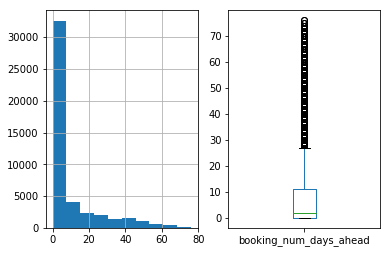

In [74]:
plt.subplot(121)
price.loc[price['month'] == 5, 'booking_num_days_ahead'].hist()

plt.subplot(122)
price.loc[price['month'] == 5, 'booking_num_days_ahead'].plot(kind = 'box')

# Combine Price History with Listing Data

#### Keep only listings with bookings

In [75]:
keep = price['scraping_id'].unique()
listing.loc[~listing['scraping_id'].isin(keep), 'exclude'] = 1
listing['exclude'].value_counts(normalize = True)

1    0.510716
0    0.489284
Name: exclude, dtype: float64

### Add summarized pricing data

#### Average price by day of week

In [76]:
temp = price.groupby(['scraping_id', 'weekday'])['calc_price'].mean().unstack()
temp.columns = ['meanPrice_'+x  for x in temp.columns]
listing = listing.merge(temp, how = 'left', on = 'scraping_id')

#### Average price by month and day of week

In [77]:
temp = price.groupby(['scraping_id', 'mon_weekday'])['calc_price'].mean().unstack()
temp.columns = ['meanPrice_'+x  for x in temp.columns]
listing = listing.merge(temp, how = 'left', on = 'scraping_id')

#### Average price by month

In [78]:
temp = price.groupby(['scraping_id', 'month'])['calc_price'].mean().unstack()
temp.columns = ['meanPriceMonth_'+str(x)  for x in temp.columns]
listing = listing.merge(temp, how = 'left', on = 'scraping_id')

#### Min, max, and min price.

In [79]:
temp = price.groupby(['scraping_id'])['calc_price'].agg(['mean', 'max', 'min'])
temp.columns = [x+'_price'  for x in temp.columns]
listing = listing.merge(temp, how = 'left', on = 'scraping_id')

#### Number of booked days

In [80]:
temp = price.groupby(['scraping_id', 'month']).size().unstack()
temp.columns = ['num_bookedDays_Apr', 'num_bookedDays_May']
listing = listing.merge(temp, how = 'left', on = 'scraping_id')

#### Occupancy Ratio

Account for some listings are newly listed.

In [81]:
listing['me_apr'] = dt.date(year = 2018, month = 4, day = 30)
listing['me_apr'] = pd.to_datetime(listing['me_apr'])
listing['ava_apr'] =  (listing['me_apr']-listing['scraped_date_min']).dt.days
listing['ava_apr'] = np.where(listing['ava_apr']>30, 30, listing['ava_apr'])
listing['ava_apr'] = np.where(listing['ava_apr']<=1, 1, listing['ava_apr'])

In [82]:
listing['me_may'] = dt.date(year = 2018, month = 5, day = 31)
listing['me_may'] = pd.to_datetime(listing['me_may'])
listing['ava_may'] =  (listing['me_may']-listing['scraped_date_min']).dt.days
listing['ava_may'] = np.where(listing['ava_may']>31, 31, listing['ava_may'])
listing['ava_may'] = np.where(listing['ava_may']<=1, 1, listing['ava_may'])

In [83]:
del listing['me_may']
del listing['me_apr']

In [84]:
listing['num_bookedDays_Apr'] = listing['num_bookedDays_Apr'].fillna(0)
listing['num_bookedDays_May'] = listing['num_bookedDays_May'].fillna(0)

In [85]:
listing['occupancy_ratio_Apr'] = listing['num_bookedDays_Apr']/listing['ava_apr']
listing['occupancy_ratio_May'] = listing['num_bookedDays_May']/listing['ava_may']
listing['occupancy_ratio_all'] = (listing['num_bookedDays_Apr']+listing['num_bookedDays_May'])/(listing['ava_apr']+listing['ava_may'])

In [86]:
listing['occupancy_ratio_Apr'] = listing['occupancy_ratio_Apr'].fillna(0)
listing['occupancy_ratio_May'] = listing['occupancy_ratio_May'].fillna(0)
listing['occupancy_ratio_all'] = listing['occupancy_ratio_all'].fillna(0)

#### Number of separating Bookings (use to estimate cleaning fee)

Estimate using count of unique'booked_date' during th month if available.  If not available, count as 1.  Will not be able to capture instances where different people make separate bookings on the same day.  It will count as 1.

In [87]:
temp = price.groupby(['scraping_id', 'month'])['booked_date'].nunique().unstack()
temp.columns = [str(x)+'_num_booking'  for x in temp.columns]
listing = listing.merge(temp, how = 'left', on = 'scraping_id')

/home/kiki/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:3766: FutureWarning: In the future, NAT != NAT will be True rather than False.
  inc = np.r_[1, val[1:] != val[:-1]]


In [88]:
listing.loc[(listing['occupancy_ratio_Apr'] == 0) & (listing['4_num_booking'].isnull()== True), '4_num_booking'] = 0
listing.loc[(listing['occupancy_ratio_May'] == 0) & (listing['5_num_booking'].isnull()== True), '5_num_booking'] = 0

In [89]:
listing.loc[(listing['num_bookedDays_Apr'] >= 1) & (listing['4_num_booking']==0), '4_num_booking'] = 1
listing.loc[(listing['num_bookedDays_May'] >= 1) & (listing['5_num_booking']==0), '5_num_booking'] = 1

#### Estimate revenue

In [90]:
temp = price.groupby(['scraping_id', 'month'])['calc_price'].sum().unstack()
temp.columns = [str(x)+'_rev_ex_clean'  for x in temp.columns]
listing = listing.merge(temp, how = 'left', on = 'scraping_id')
listing['4_rev_ex_clean'] = listing['4_rev_ex_clean'].fillna(0)

In [91]:
listing['4_rev_ex_clean'] = listing['4_rev_ex_clean'].fillna(0)
listing['5_rev_ex_clean'] = listing['5_rev_ex_clean'].fillna(0)

In [92]:
listing['apr_cleaning_revenue']=listing['cleaning_fee']*listing['4_num_booking']
listing['may_cleaning_revenue']=listing['cleaning_fee']*listing['5_num_booking']

In [93]:
listing['apr_total_revenue']=listing['4_rev_ex_clean']+listing['apr_cleaning_revenue']
listing['may_total_revenue']=listing['5_rev_ex_clean']+listing['may_cleaning_revenue']

#### Add price with cleaning fee factored in

Adjust price by assuming 3 day booking.  Daily price + 1/3 of cleaning fee.

In [94]:
price = price.merge(listing[['scraping_id', 'cleaning_fee']], how = 'left', on = 'scraping_id')

In [95]:
price['calc_price_w_cleanFee'] = price['calc_price'] + (price['cleaning_fee']*1/3)
del price['cleaning_fee']

In [96]:
listing['Total_Revenue_May_Apr'] = listing['apr_total_revenue'] + listing['may_total_revenue']
listing['price_w_cleaning'] = listing['mean_price']+listing['cleaning_fee']*(1/3)

#### Change columns names

In [97]:
listing.columns = ['scraping_id', 'listing', 'city', 'lon', 'lat', 'mapped_location',
       'name', 'capacity', 'bathrooms', 'bedrooms', 'has_pool', 'cleaning_fee',
       'is_superhost', 'host_name', 'exclude', 'bed_bath', 'bed_bath_ratio',
       'scraped_date_min', 'manager', 'meanPrice_Fri', 'meanPrice_Mon',
       'meanPrice_Sat', 'meanPrice_Sun', 'meanPrice_Thu', 'meanPrice_Tue',
       'meanPrice_Wed', 'meanPrice_Apr_Fri', 'meanPrice_Apr_Mon',
       'meanPrice_Apr_Sat', 'meanPrice_Apr_Sun', 'meanPrice_Apr_Thu',
       'meanPrice_Apr_Tue', 'meanPrice_Apr_Wed', 'meanPrice_May_Fri',
       'meanPrice_May_Mon', 'meanPrice_May_Sat', 'meanPrice_May_Sun',
       'meanPrice_May_Thu', 'meanPrice_May_Tue', 'meanPrice_May_Wed',
       'meanPriceMonth_Apr', 'meanPriceMonth_May', 'mean_price', 'max_price',
       'min_price', 'num_bookedDays_Apr', 'num_bookedDays_May', 'ava_apr',
       'ava_may', 'occupancy_ratio_Apr', 'occupancy_ratio_May',
       'occupancy_ratio_all', 'Apr_num_booking', 'May_num_booking',
       'Apr_rev_ex_clean', 'May_rev_ex_clean', 'Apr_cleaning_revenue',
       'May_cleaning_revenue', 'Apr_total_revenue', 'May_total_revenue','Total_Revenue_May_Apr', 'price_w_cleaning']

#### Save file

In [98]:
price.to_pickle(PATH+'/price.pkl')
listing.to_pickle(PATH+'/listing.pkl')

In [99]:
#price = pd.read_pickle(PATH+'/price.pkl')
#listing = pd.read_pickle(PATH+'/listing.pkl')

In [100]:
display_all(listing.loc[listing['host_name'] == 'WanderJaunt'])

,scraping_id,listing,city,lon,lat,mapped_location,name,capacity,bathrooms,bedrooms,has_pool,cleaning_fee,is_superhost,host_name,exclude,bed_bath,bed_bath_ratio,scraped_date_min,manager,meanPrice_Fri,meanPrice_Mon,meanPrice_Sat,meanPrice_Sun,meanPrice_Thu,meanPrice_Tue,meanPrice_Wed,meanPrice_Apr_Fri,meanPrice_Apr_Mon,meanPrice_Apr_Sat,meanPrice_Apr_Sun,meanPrice_Apr_Thu,meanPrice_Apr_Tue,meanPrice_Apr_Wed,meanPrice_May_Fri,meanPrice_May_Mon,meanPrice_May_Sat,meanPrice_May_Sun,meanPrice_May_Thu,meanPrice_May_Tue,meanPrice_May_Wed,meanPriceMonth_Apr,meanPriceMonth_May,mean_price,max_price,min_price,num_bookedDays_Apr,num_bookedDays_May,ava_apr,ava_may,occupancy_ratio_Apr,occupancy_ratio_May,occupancy_ratio_all,Apr_num_booking,May_num_booking,Apr_rev_ex_clean,May_rev_ex_clean,Apr_cleaning_revenue,May_cleaning_revenue,Apr_total_revenue,May_total_revenue,Total_Revenue_May_Apr,price_w_cleaning
16,19,https://www.airbnb.com/rooms/16603819,scottsdale,-111.923028,33.509476,https://maps.google.com/maps?q=33.509475637590...,Modern 2BR by Old Town #12 by WanderJaunt,6,2.0,2.0,1,115.0,1,WanderJaunt,0,2.0_2.0,1.000000,2018-03-15,1,124.571429,83.142857,118.666667,85.285714,102.571429,89.571429,87.285714,143.333333,86.250000,122.333333,88.333333,121.000000,100.000000,93.666667,110.500000,79.000000,115.000000,83.000000,88.750000,81.750000,82.500000,106.863636,91.076923,98.312500,175.0,67.0,22.0,26.0,30.0,31.0,0.733333,0.838710,0.786885,6.0,9.0,2351.0,2368.0,690.0,1035.0,3041.0,3403.0,6444.0,136.645836
49,56,https://www.airbnb.com/rooms/17367967,scottsdale,-111.937846,33.493193,https://maps.google.com/maps?q=33.493193249954...,Modern 3BR in Central Scottsdale by WanderJaunt,8,2.0,3.0,0,120.0,1,WanderJaunt,0,3.0_2.0,1.500000,2018-03-15,1,135.571429,111.666667,142.000000,107.200000,107.500000,114.250000,111.400000,161.666667,127.500000,150.000000,125.333333,128.333333,145.000000,138.500000,116.000000,80.000000,136.666667,80.000000,95.000000,83.500000,93.333333,139.294118,101.800000,119.027027,188.0,70.0,17.0,20.0,30.0,31.0,0.566667,0.645161,0.606557,4.0,7.0,2368.0,2036.0,480.0,840.0,2848.0,2876.0,5724.0,159.027027
219,247,https://www.airbnb.com/rooms/20054611,scottsdale,-111.934413,33.486424,https://maps.google.com/maps?q=33.486424461656...,4BR Modern Townhouse near Old Town by WanderJaunt,8,2.5,4.0,1,160.0,1,WanderJaunt,0,4.0_2.5,1.600000,2018-03-15,1,190.666667,131.750000,175.166667,132.500000,170.333333,128.000000,149.500000,233.666667,147.500000,245.500000,157.000000,208.500000,156.500000,186.000000,147.666667,116.000000,140.000000,108.000000,151.250000,109.000000,137.333333,191.600000,131.954545,156.135135,268.0,92.0,15.0,22.0,30.0,31.0,0.500000,0.709677,0.606557,2.0,2.0,2874.0,2903.0,320.0,320.0,3194.0,3223.0,6417.0,209.468471
563,953,https://www.airbnb.com/rooms/20864587,scottsdale,-111.911771,33.553366,https://maps.google.com/maps?q=33.553366172307...,Luxe Scottsdale Home near Camelback by WanderJ...,6,3.0,3.0,0,175.0,1,WanderJaunt,1,3.0_3.0,1.000000,2018-03-15,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,30.0,31.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1136,1710,https://www.airbnb.com/rooms/20912960,phoenix,-112.070294,33.459581,https://maps.google.com/maps?q=33.459581183292...,1BR Converted Cargo Container #203 by WanderJaunt,4,1.0,1.0,0,90.0,1,WanderJaunt,0,1.0_1.0,1.000000,2018-03-15,1,108.000000,89.600000,99.500000,92.666667,88.500000,85.400000,94.250000,108.500000,112.666667,114.000000,104.000000,92.000000,105.666667,102.333333,107.000000,55.000000,85.000000,70.000000,85.000000,55.000000,70.000000,105.312500,72.200000,92.576923,134.0,40.0,16.0,10.0,30.0,31.0,0.533333,0.322581,0.426230,2.0,4.0,1685.0,722.0,180.0,360.0,1865.0,1082.0,2947.0,122.576923
3745,13217,https://www.airbnb.com/rooms/16132761,scottsdale,-111.943094,33.470602,https://maps.google.com/maps?q=33.470602424732...,Private Pool | 3BR | Great Location by WanderJ...,8,2.0,3.0,1

#### Property type excluded.

Properties without any booking are pretty evenly distributed between the different bedroom types.

In [101]:
pd.crosstab(index=listing['bedrooms'], columns = listing['exclude'], normalize= True, margins= True)

exclude,0,1,All
bedrooms,,,
0.0,0.020367,0.022972,0.043339
1.0,0.103967,0.101717,0.205684
2.0,0.159976,0.151332,0.311308
3.0,0.102309,0.132031,0.234340
4.0,0.068324,0.066667,0.134991
5.0,0.021788,0.025340,0.047128
6.0,0.007342,0.007697,0.015038
7.0,0.002013,0.001303,0.003316
8.0,0.002131,0.001303,0.003434
